In [1]:
import time
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

/home/bmartins/anaconda3/envs/rl_study/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set up environment
import ale_py

gym.register_envs(ale_py)  # unnecessary but helpful for IDEs
env_name = 'Pong-v0'
env = gym.make(env_name, render_mode='rgb_array')
state_size = (84, 84, 1)  # Single frame for simplicity
action_size = env.action_space.n
buffer_size = 100000
batch_size = 64
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon

In [3]:
def frame_preprocessing(observation_frame):
    # Crop the frame.
    observation_frame = observation_frame[35:195]
    # Downsample the frame by a factor of 2.
    observation_frame = observation_frame[::2, ::2, 0]
    # Remove the background and apply other enhancements.
    observation_frame[observation_frame == 144] = 0  # Erase the background (type 1).
    observation_frame[observation_frame == 109] = 0  # Erase the background (type 2).
    observation_frame[observation_frame != 0] = 1  # Set the items (rackets, ball) to 1.
    # Return the preprocessed frame as a 1D floating-point array.
    return observation_frame.astype(float)

In [ ]:
# Preprocess frame
def preprocess_frame(frame):
    """
    Convert frame to grayscale, crop, resize to 84x84, and normalize.
    Returns a (84, 84) numpy array with values in [0, 1].
    """
    # Convert to grayscale
    frame = np.mean(frame, axis=2).astype(np.uint8)
    
    # Crop the screen to focus on the playing area (remove score and borders)
    frame = frame[34:194]  # Height: 210 -> 160
    
    # Resize to 84x84 using cv2
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    
    # Normalize pixel values to [0, 1]
    frame = frame.astype(np.float32) / 255.0
    
    return frame

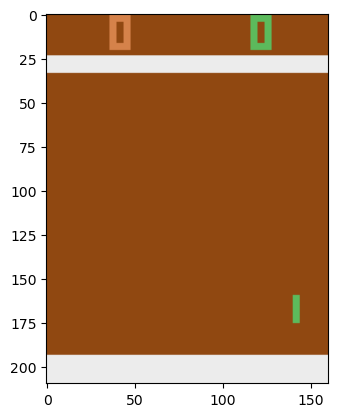

In [ ]:
# play the game using a random policy and render the frames in the notebook
obs, info = env.reset() 
obs = preprocess_frame(obs)
done = False
total_reward = 0
    
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    plt.imshow(obs) 
    plt.show()
    clear_output(wait=True)
    obs = preprocess_frame(obs)
    total_reward += reward
        
    if terminated or truncated:
        done = True
            
time.sleep(1)

env.close() 



In [ ]:
# play the game with the UI using a random policy 
def play_random_policy(env, num_episodes=10):
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample()  # Random action
            obs, reward, done, _, _ = env.step(action)
            total_reward += reward
        env.render()  # Render the environment
        time.sleep(1)
        env.close()

play_random_policy(env, num_episodes=3)

In [ ]:
# Build neural network model
class DQN(nn.Module):
    def __init__(self, input_shape, action_size):
        super(DQN, self).__init__()
        self.input_shape = input_shape  # Expected: (batch_size, channels, height, width)
        
        # Convolutional layers - designed for (1, 84, 84) input
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),  # (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # (64, 7, 7)
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Calculate the output size of conv layers
        self.conv_output_size = self._get_conv_output()
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output(self):
        """
        Helper method to get the output size of the convolutional layers.
        """
        # Create dummy input with shape (batch_size=1, channels=1, height=84, width=84)
        dummy_input = torch.randn(1, 1, 84, 84)
        output = self.conv_layers(dummy_input)
        return output.size(1)
    
    def forward(self, x):
        """
        Forward pass of the network.
        Input: (batch_size, 84, 84) - single channel grayscale frames
        Returns Q-values for each action.
        """
        # Add channel dimension if needed: (batch_size, 84, 84) -> (batch_size, 1, 84, 84)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Input is already normalized in preprocessing, no need to normalize again
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
obs, _ = env.reset()
print("Original obs shape:", obs.shape)
state = preprocess_frame(obs)
print("Processed state shape:", state.shape)
state_tensor = torch.tensor(np.array([state]), dtype=torch.float32)
print("State tensor shape:", state_tensor.shape)
action_size = env.action_space.n
model = DQN((1, 84, 84), action_size).float()  # Use correct input shape
q_values = model(state_tensor)
print("Q-values shape:", q_values.shape)
action = 0
step = env.step(action)
print("Step info:", step[4])

In [ ]:
env.observation_space.shape, state_tensor.shape

((210, 160, 3), torch.Size([1, 84, 84]))

In [ ]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])


class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

In [ ]:
GAMMA = 0.99
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state, info = self.env.reset()
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()  # Use self.env instead of global env
        else:
            state_a = np.array([preprocess_frame(self.state)], copy=False)
            state_v = torch.tensor(state_a, dtype=torch.float32).to(device)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(preprocess_frame(self.state), action, reward, is_done, preprocess_frame(new_state))
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward


def calc_loss(batch, net, tgt_net, device="cpu"):
    states, actions, rewards, dones, next_states = batch

    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions, dtype=torch.long).to(device)
    rewards_v = torch.tensor(rewards, dtype=torch.float32).to(device)
    done_mask = torch.tensor(dones, dtype=torch.bool).to(device)  # Use bool instead of ByteTensor

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]
    next_state_values[done_mask] = 0.0
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [ ]:
def play_policy(env, net, device, sleep_time=0.05):
    obs, info = env.reset() 
    done = False
    total_reward = 0
        
    while not done:
        state_a = np.array([preprocess_frame(obs)], copy=False)
        state_v = torch.tensor(state_a).to(device)
        q_vals_v = net(state_v)
        _, act_v = torch.max(q_vals_v, dim=1)
        action = int(act_v.item())
        
        # do step in the environment
        obs, reward, terminated, truncated, info = env.step(action)
        plt.imshow(obs) 
        plt.show()
        clear_output(wait=True)
        total_reward += reward
            
        if terminated or truncated:
            done = True
                
        time.sleep(sleep_time)
    env.close() 
    return total_reward

In [ ]:
MEAN_REWARD_BOUND = 19.5

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 50000
LEARNING_RATE = 1e-4  # Reduced from 1e-2 for more stable training
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

EPSILON_DECAY_LAST_FRAME = 10**6
EPSILON_START = 1.0
EPSILON_FINAL = 0.02

In [ ]:
# Training loop setup
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize networks and optimizer with correct input shape
net = DQN((1, 84, 84), env.action_space.n).to(device)
tgt_net = DQN((1, 84, 84), env.action_space.n).to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# Initialize buffers and tracking variables
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None
reward_history = []

while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
    reward = agent.play_step(net, epsilon, device=device)
    
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts)
        ts_frame = frame_idx
        ts = time.time()
        mean_reward = np.mean(total_rewards[-100:])
        reward_history.append(mean_reward)
        
        # Print progress
        print(f"Frame {frame_idx}: games={len(total_rewards)}, "
              f"mean reward={mean_reward:.3f}, eps={epsilon:.2f}, "
              f"speed={speed:.2f} f/s")
        
        # Check for best reward
        if best_mean_reward is None or best_mean_reward < mean_reward:
            if best_mean_reward is not None:
                print(f"Best mean reward updated {best_mean_reward:.3f} -> {mean_reward:.3f}")
            best_mean_reward = mean_reward
            
        # Check if solved
        if mean_reward > MEAN_REWARD_BOUND:
            print(f"Solved in {frame_idx} frames!")
            break

    # Skip until we have enough data
    if len(buffer) < REPLAY_START_SIZE:
        continue

    # Periodic target network update and visualization
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())
        
        # Update plot
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(reward_history)
        plt.title('Training Progress')
        plt.xlabel('Episodes')
        plt.ylabel('Mean Reward')
        plt.grid(True)
        plt.show()
    
    # Training step
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device=device)
    loss_t.backward()
    optimizer.step()